# Промежуточная аттестация 2

## Задача NLP -- анализ тональности

## 1. Настройка окружения и импорт зависимостей
Собираем все библиотеки, настраиваем предупреждения и загружаем ресурсы NLTK/transformers.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pymorphy2
from nltk.tokenize import word_tokenize
from pathlib import Path

print("Скачивание ресурсов NLTK...")
if False:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    nltk.download('punkt_tab')  # Дополнительный ресурс
    nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import torch
from transformers import AutoTokenizer, AutoModel, pipeline
from datasets import load_dataset, Dataset

import warnings
warnings.filterwarnings('ignore')

corp_col = '#40ba21'
corp_alt = '#2c7c16'
c_map = sns.light_palette(corp_col, as_cmap=True)
CACHE_DIR = Path('cache_outputs')
CACHE_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")


Скачивание ресурсов NLTK...


f:\Staff\Иннополис\Innopolis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Используемое устройство: cuda


## 2. Загрузка корпуса токсичных комментариев
Читаем jsonl напрямую из репозитория AlexSham/Toxic_Russian_Comments на Hugging Face и приводим метки к нужному виду.


In [2]:

import pandas as pd

DATASET_REPO = "AlexSham/Toxic_Russian_Comments"
HF_TRAIN_URI = f"hf://datasets/{DATASET_REPO}/train.jsonl"
HF_TEST_URI  = f"hf://datasets/{DATASET_REPO}/test.jsonl"

train_data = pd.read_json(HF_TRAIN_URI, lines=True)
test_data  = pd.read_json(HF_TEST_URI,  lines=True)

train_data['label'] = train_data['label'].map({1: 0, 0: 1})
test_data['label'] = test_data['label'].map({1: 0, 0: 1})

In [3]:
print("train shape:", train_data.shape, "test shape:", test_data.shape)
display(train_data.head(10))

train shape: (223461, 2) test shape: (24829, 2)


,text,label
0,"видимо в разных регионах называют по разному ,...",1
1,"понятно что это нарушение правил, писать капсл...",0
2,"какие классные, жизненные стихи....",1
3,а и правда-когда его запретили?...,1
4,в соленой воде вирусы живут .ученые изучали со...,1
5,правильно! это же тихановская 26 лет растила и...,0
6,ни в одном из близлежащих строительных не нашл...,1
7,"какая дрянь сломала? виноваты родители, выраст...",1
8,"да, висели такие на стене, над кроватью. в люб...",1
9,потому что мы так воспитаны,1


#### 2.1 Первичный анализ и разведка данных
Создаем DataFrame, смотрим примеры текстов и распределение классов.


Размер обучающей выборки: 223461
Размер тестовой выборки: 24829


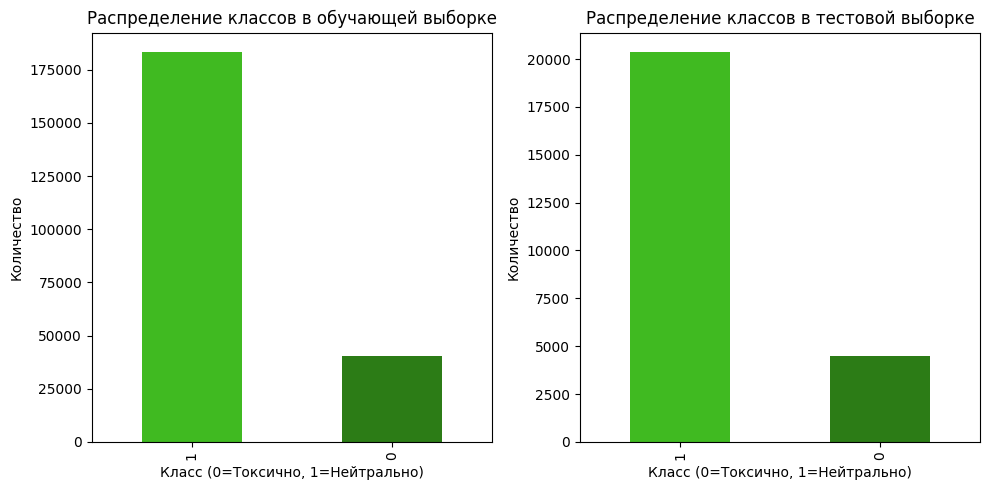

In [4]:

df_train = pd.DataFrame({'text': train_data['text'], 'label': train_data['label']})
df_test = pd.DataFrame({'text': test_data['text'], 'label': test_data['label']})

print(f"Размер обучающей выборки: {len(df_train)}")
print(f"Размер тестовой выборки: {len(df_test)}")

bar_palette = [corp_col, corp_alt]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df_train['label'].value_counts().plot(kind='bar', color=bar_palette)
plt.title('Распределение классов в обучающей выборке')
plt.xlabel('Класс (0=Токсично, 1=Нейтрально)')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
df_test['label'].value_counts().plot(kind='bar', color=bar_palette)
plt.title('Распределение классов в тестовой выборке')
plt.xlabel('Класс (0=Токсично, 1=Нейтрально)')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()


## 3. Предобработка текста

Приведение к нижнему регистру, фильтрация символов, токенизация и лемматизация. Стоп слова не убирались, так как это лишено смысла для данного набора данных.

In [5]:
class TextPreprocessor:
    def __init__(self):
        # self.stop_words = set(stopwords.words('russian')) НЕ ИМЕЕТ СМЫСЛА ДЛЯ ДАННОГО НАБОРА ДАННЫХ
        self.morph = pymorphy2.MorphAnalyzer()

    def preprocess_text(self, text):
        text = text.lower()
        text = re.sub(r'[^а-яА-ЯёЁ\s]', '', text)
        tokens = word_tokenize(text)

        lemmas = []
        for token in tokens:
            if len(token) <= 2:
                continue
            lemma = self.morph.parse(token)[0].normal_form
            lemmas.append(lemma)

        return ' '.join(lemmas)

preprocessor = TextPreprocessor()


#### 3.1 Применение предобработки и формирование сэмплов
Берем подвыборку (5000/1000 объектов) для ускорения экспериментов и применяем очистку.


In [6]:

# Применяем предобработку к данным (для ускорения возьмем подвыборку)
print("Предобработка текстов...")

# Для демонстрации возьмем 5000 samples из train и 1000 из test
sample_size_train = 5000
sample_size_test = 1000

df_train_sampled = df_train.sample(sample_size_train, random_state=42)
df_test_sampled = df_test.sample(sample_size_test, random_state=42)

# Применяем предобработку
df_train_sampled['cleaned_text'] = df_train_sampled['text'].apply(preprocessor.preprocess_text)
df_test_sampled['cleaned_text'] = df_test_sampled['text'].apply(preprocessor.preprocess_text)

# Посмотрим на результат предобработки
print("Пример до предобработки:")
print(df_train_sampled['text'].iloc[0][:200])
print("\nПример после предобработки:")
print(df_train_sampled['cleaned_text'].iloc[0][:200])


Предобработка текстов...
Пример до предобработки:
изморозь на валенках

Пример после предобработки:
изморозить валенок


## 4. Классический подход: TF-IDF + Logistic Regression
В этой части сравниваем разные конфигурации TF-IDF и фиксируем результаты лучшей модели.


### 4.1 Эксперименты с конфигурациями TF-IDF
Перебираем несколько сочетаний max_features и ngram_range, фиксируя метрики и обученные модели.


In [7]:

print("Эксперименты с TF-IDF векторизацией...")

tfidf_configs = [
    {'max_features': 3000, 'ngram_range': (1, 1), 'name': 'TF-IDF Basic (1-grams)'},
    {'max_features': 5000, 'ngram_range': (1, 1), 'name': 'TF-IDF Large Vocab (1-grams)'},
    {'max_features': 3000, 'ngram_range': (1, 2), 'name': 'TF-IDF Basic (1-2 grams)'},
    {'max_features': 5000, 'ngram_range': (1, 2), 'name': 'TF-IDF Large Vocab (1-2 grams)'},
    {'max_features': 5000, 'ngram_range': (1, 3), 'name': 'TF-IDF Extended (1-3 grams)'},
    {'max_features': 8000, 'ngram_range': (1, 2), 'name': 'TF-IDF Extended Vocab (1-2 grams)'}
]

results = []
models = {}
vectorizers = {}

for i, config in enumerate(tfidf_configs):
    print(f"\n--- Эксперимент {i+1}: {config['name']} ---")
    print(f"Параметры: max_features={config['max_features']}, ngram_range={config['ngram_range']}")

    tfidf_vectorizer = TfidfVectorizer(
        max_features=config['max_features'],
        ngram_range=config['ngram_range'],
        min_df=2,
        max_df=0.8,
        stop_words='english',
        sublinear_tf=True
    )

    print("Векторизация текстов...")
    X_train_tfidf = tfidf_vectorizer.fit_transform(df_train_sampled['cleaned_text'])
    X_test_tfidf = tfidf_vectorizer.transform(df_test_sampled['cleaned_text'])

    y_train = df_train_sampled['label']
    y_test = df_test_sampled['label']

    print(f"Размерность матрицы: {X_train_tfidf.shape}")

    feature_names = tfidf_vectorizer.get_feature_names_out()
    print(f"Размер словаря: {len(feature_names)}")
    print("Примеры features:", feature_names[:10] if len(feature_names) > 10 else feature_names)

    lr_model = LogisticRegression(
        random_state=42,
        max_iter=1000,
        C=1.0,
        solver='liblinear'
    )

    lr_model.fit(X_train_tfidf, y_train)
    y_pred = lr_model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'config_name': config['name'],
        'max_features': config['max_features'],
        'ngram_range': config['ngram_range'],
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'vocabulary_size': len(feature_names),
        'matrix_shape': X_train_tfidf.shape
    })

    models[config['name']] = lr_model
    vectorizers[config['name']] = tfidf_vectorizer

    print(f"Результаты: Accuracy={accuracy:.4f}, F1={f1:.4f}")

results_df = pd.DataFrame(results)
print("" + "="*80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ TF-IDF ЭКСПЕРИМЕНТОВ")
print("="*80)
print(results_df.round(4))


Эксперименты с TF-IDF векторизацией...

--- Эксперимент 1: TF-IDF Basic (1-grams) ---
Параметры: max_features=3000, ngram_range=(1, 1)
Векторизация текстов...
Размерность матрицы: (5000, 3000)
Размер словаря: 3000
Примеры features: ['абсолютно' 'абхазия' 'авг' 'август' 'автобус' 'автомат' 'автомобиль'
 'автоперевод' 'автор' 'авторизация']
Результаты: Accuracy=0.8800, F1=0.9314

--- Эксперимент 2: TF-IDF Large Vocab (1-grams) ---
Параметры: max_features=5000, ngram_range=(1, 1)
Векторизация текстов...
Размерность матрицы: (5000, 3824)
Размер словаря: 3824
Примеры features: ['абсолютно' 'абхазия' 'авг' 'август' 'автобус' 'автомат' 'автомобиль'
 'автоперевод' 'автор' 'авторизация']
Результаты: Accuracy=0.8810, F1=0.9320

--- Эксперимент 3: TF-IDF Basic (1-2 grams) ---
Параметры: max_features=3000, ngram_range=(1, 2)
Векторизация текстов...
Размерность матрицы: (5000, 3000)
Размер словаря: 3000
Примеры features: ['абхазия' 'авг' 'авг ответить' 'август' 'автомобиль' 'автор'
 'авторизация' '

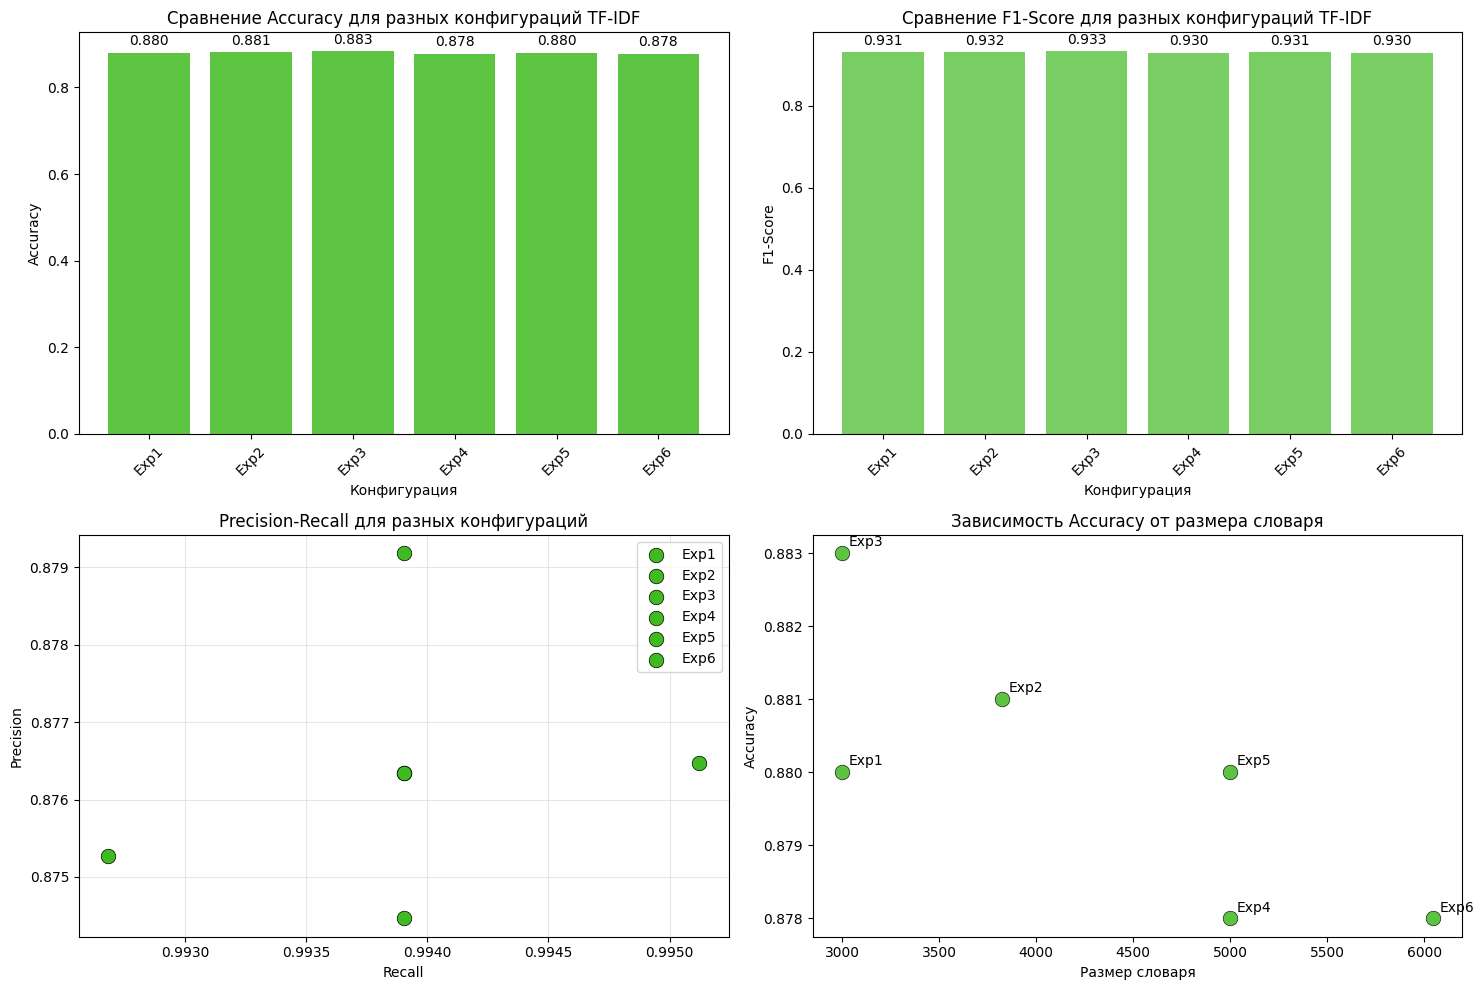

In [8]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
bars = plt.bar(range(len(results_df)), results_df['accuracy'], color=corp_col, alpha=0.85)
plt.title('Сравнение Accuracy для разных конфигураций TF-IDF')
plt.xlabel('Конфигурация')
plt.ylabel('Accuracy')
plt.xticks(range(len(results_df)), [f"Exp{i+1}" for i in range(len(results_df))], rotation=45)
for bar, value in zip(bars, results_df['accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.3f}',
             ha='center', va='bottom')

plt.subplot(2, 2, 2)
bars = plt.bar(range(len(results_df)), results_df['f1'], color=corp_col, alpha=0.7)
plt.title('Сравнение F1-Score для разных конфигураций TF-IDF')
plt.xlabel('Конфигурация')
plt.ylabel('F1-Score')
plt.xticks(range(len(results_df)), [f"Exp{i+1}" for i in range(len(results_df))], rotation=45)
for bar, value in zip(bars, results_df['f1']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.3f}',
             ha='center', va='bottom')

plt.subplot(2, 2, 3)
for i, row in results_df.iterrows():
    plt.scatter(row['recall'], row['precision'], label=f"Exp{i+1}", s=110,
                color=corp_col, edgecolor='black', linewidth=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall для разных конфигураций')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.scatter(results_df['vocabulary_size'], results_df['accuracy'], s=110, alpha=0.85,
            color=corp_col, edgecolor='black', linewidth=0.5)
plt.xlabel('Размер словаря')
plt.ylabel('Accuracy')
plt.title('Зависимость Accuracy от размера словаря')
for i, row in results_df.iterrows():
    plt.annotate(f"Exp{i+1}", (row['vocabulary_size'], row['accuracy']),
                 xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


В целом, разница для экспериментов незначительна!

In [9]:
best_config_idx = results_df['f1'].idxmax()
best_config = results_df.iloc[best_config_idx]
best_model_name = best_config['config_name']

print("" + "="*60)
print("ЛУЧШАЯ КОНФИГУРАЦИЯ TF-IDF")
print("="*60)
print(f"Конфигурация: {best_config['config_name']}")
print(f"Параметры: max_features={best_config['max_features']}, ngram_range={best_config['ngram_range']}")
print(f"Accuracy: {best_config['accuracy']:.4f}")
print(f"F1-Score: {best_config['f1']:.4f}")
print(f"Precision: {best_config['precision']:.4f}")
print(f"Recall: {best_config['recall']:.4f}")


ЛУЧШАЯ КОНФИГУРАЦИЯ TF-IDF
Конфигурация: TF-IDF Basic (1-2 grams)
Параметры: max_features=3000, ngram_range=(1, 2)
Accuracy: 0.8830
F1-Score: 0.9330
Precision: 0.8792
Recall: 0.9939


Детальный отчет для лучшей модели:
              precision    recall  f1-score   support

    Negative       0.94      0.38      0.54       886
    Positive       0.88      0.99      0.93      4114

    accuracy                           0.89      5000
   macro avg       0.91      0.69      0.74      5000
weighted avg       0.89      0.89      0.86      5000



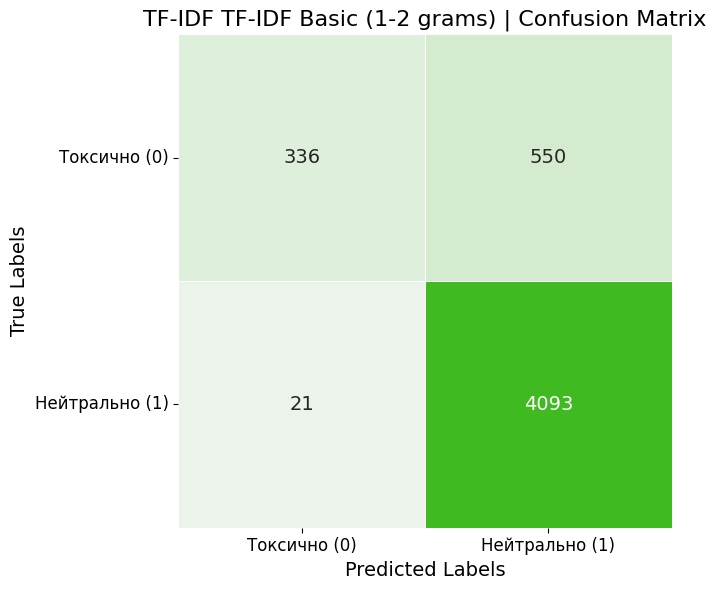

In [10]:

df_train_sampled = df_train.sample(50000, random_state=42)
df_test_sampled = df_test.sample(5000, random_state=42)

df_train_sampled['cleaned_text'] = df_train_sampled['text'].apply(preprocessor.preprocess_text)
df_test_sampled['cleaned_text'] = df_test_sampled['text'].apply(preprocessor.preprocess_text)

best_lr_model = models[best_model_name]
best_tfidf_vectorizer = vectorizers[best_model_name]
X_train_best = best_tfidf_vectorizer.transform(df_train_sampled['cleaned_text'])
X_test_best = best_tfidf_vectorizer.transform(df_test_sampled['cleaned_text'])
y_test_best = df_test_sampled['label']
y_pred_best = best_lr_model.predict(X_test_best)

print("" + "="*60)
print("Детальный отчет для лучшей модели:")
print("="*60)
print(classification_report(y_test_best, y_pred_best, target_names=['Negative', 'Positive']))

cm_best = confusion_matrix(y_test_best, y_pred_best)
key = f"TF-IDF {best_model_name}"

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_best,
    annot=True,
    fmt="d",
    cmap=c_map,
    linewidths=.5,
    square=True,
    cbar=False,
    annot_kws={"size": 14}
)
plt.title(f'{key} | Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks([0.5, 1.5], ['Токсично (0)', 'Нейтрально (1)'], fontsize=12)
plt.yticks([0.5, 1.5], ['Токсично (0)', 'Нейтрально (1)'], fontsize=12, rotation=0)
out_path = CACHE_DIR / f"cm_{key.lower()}.png"

plt.tight_layout()
plt.show()


### 4.2 Интерпретация признаков TF-IDF
Анализируем веса Logistic Regression, визуализируем важные положительные и отрицательные признаки.


Анализ наиболее важных признаков:
Топ-20 наиболее важных признаков для положительных отзывов:
           feature  coefficient  abs_coef
145      быть есть    -0.002446  0.002446
1218       мамочка    -0.001990  0.001990
248            вид    -0.001394  0.001394
1821    понять это    -0.000961  0.000961
1881       править    -0.000648  0.000648
163   быть хороший    -0.000404  0.000404
325         восток    -0.000263  0.000263
1308         мопед    -0.000024  0.000024
907     информация     0.000028  0.000028
1479         нефть     0.000715  0.000715
2074     разрушить     0.001271  0.001271
2215         сдать     0.001370  0.001370
65          библия     0.002103  0.002103
1213         малыш     0.002259  0.002259
2968       это наш     0.002416  0.002416
Топ-20 наиболее важных признаков для отрицательных отзывов:
['к*л', 'ж**а', 'п*****с', 'п*******й', 'н***й', 'п*****с', 'у*****к', 'д***л', 'м***ь', 'х*й', 'п***р', 'у**д', 'с**а', 'б***ь', 'т***ь']


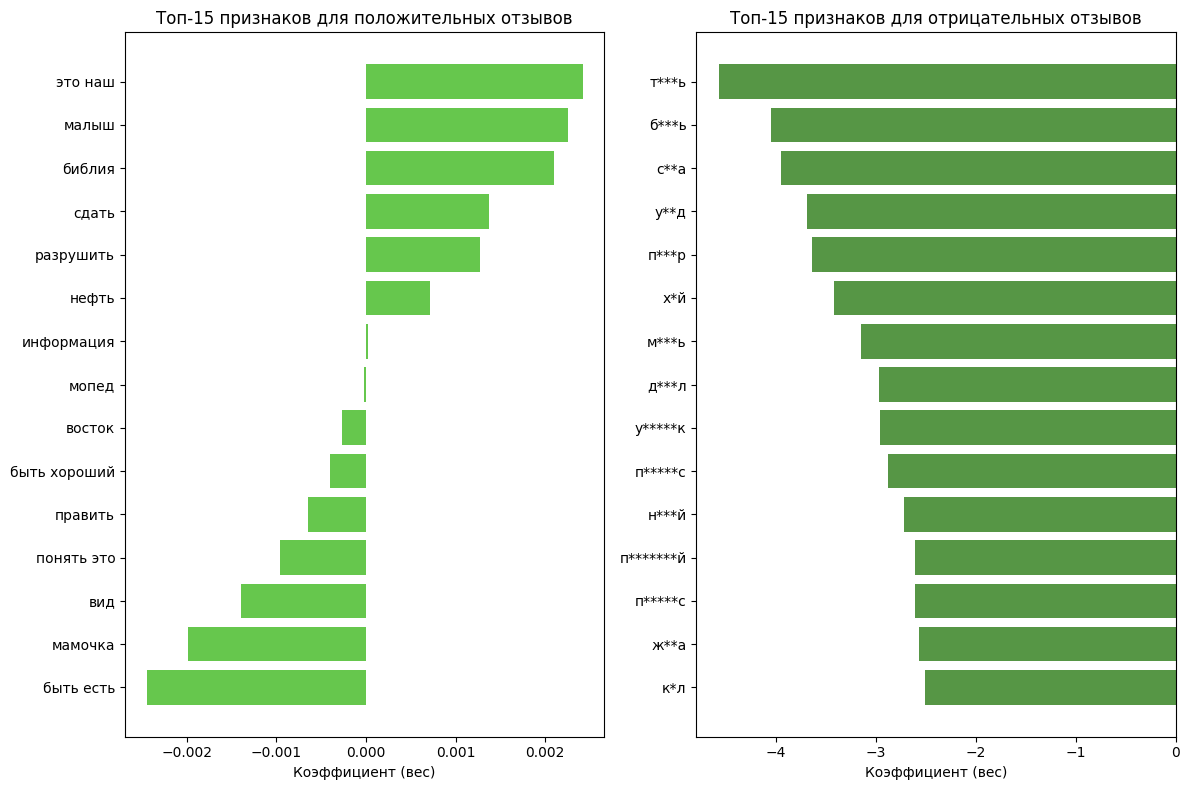

In [11]:

print("Анализ наиболее важных признаков:")

feature_names = best_tfidf_vectorizer.get_feature_names_out()
coefficients = best_lr_model.coef_[0]

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})
feature_importance['abs_coef'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coef', ascending=True)

def mask_token(token: str) -> str:
    token = str(token)
    return token if len(token) <= 2 else token[0] + '*' * (len(token) - 2) + token[-1]

top_features = 15
positive_top = feature_importance.head(top_features).sort_values('coefficient', ascending=True)
negative_top = feature_importance.tail(top_features).sort_values('coefficient', ascending=False)
masked_negative = [mask_token(word) for word in negative_top['feature']]

print("Топ-20 наиболее важных признаков для положительных отзывов:")
print(positive_top)

print("Топ-20 наиболее важных признаков для отрицательных отзывов:")
print(masked_negative )



plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.barh(range(len(positive_top)), positive_top['coefficient'], color=corp_col, alpha=0.8)
plt.yticks(range(len(positive_top)), positive_top['feature'])
plt.title(f'Топ-{top_features} признаков для положительных отзывов')
plt.xlabel('Коэффициент (вес)')

plt.subplot(1, 2, 2)

plt.barh(range(len(negative_top)), negative_top['coefficient'], color=corp_alt, alpha=0.8)
plt.yticks(range(len(negative_top)), masked_negative)
plt.title(f'Топ-{top_features} признаков для отрицательных отзывов')
plt.xlabel('Коэффициент (вес)')

plt.tight_layout()
plt.show()

best_tfidf_results = {
    'model': best_lr_model,
    'vectorizer': best_tfidf_vectorizer,
    'config': best_config.to_dict(),
    'predictions': y_pred_best,
    'metrics': {
        'accuracy': best_config['accuracy'],
        'precision': best_config['precision'],
        'recall': best_config['recall'],
        'f1': best_config['f1']
    }
}


### 4.3 Векторизация текстов лучшей конфигурацией
Используем выбранный TF-IDF векторайзер для получения матриц признаков train/test.


In [12]:
tfidf_vectorizer = best_tfidf_vectorizer
X_train_tfidf = X_train_best
X_test_tfidf = X_test_best

y_train = df_train_sampled['label']
y_test = df_test_sampled['label']

print(f"Используем конфигурацию: {best_model_name}")
print(f"Параметры: max_features={tfidf_vectorizer.max_features}, ngram_range={tfidf_vectorizer.ngram_range}")
print(f"Размерность TF-IDF матрицы (train): {X_train_tfidf.shape}")
print(f"Размерность TF-IDF матрицы (test): {X_test_tfidf.shape}")

Используем конфигурацию: TF-IDF Basic (1-2 grams)
Параметры: max_features=3000, ngram_range=(1, 2)
Размерность TF-IDF матрицы (train): (50000, 3000)
Размерность TF-IDF матрицы (test): (5000, 3000)


### 4.4 Обучение Logistic Regression на лучшей конфигурации
Финально переиспользуем лучшую модель на полном тестовом наборе.


In [13]:


# Logistic Regression на лучшей TF-IDF конфигурации
print("Используем Logistic Regression с лучшей TF-IDF конфигурацией...")

if 'best_lr_model' not in globals():
    raise RuntimeError("Сначала выполните блок экспериментов TF-IDF, чтобы выбрать лучшую модель.")

lr_model = best_lr_model

# Предсказание и оценка модели
y_pred_lr = lr_model.predict(X_test_tfidf)

# Метрики
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("=== Logistic Regression (TF-IDF) Результаты (лучшая конфигурация) ===")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")



Используем Logistic Regression с лучшей TF-IDF конфигурацией...
=== Logistic Regression (TF-IDF) Результаты (лучшая конфигурация) ===
Accuracy: 0.8858
Precision: 0.8815
Recall: 0.9949
F1-Score: 0.9348


### 4.5 Классификационный отчет и матрица ошибок (TF-IDF)
Фиксируем метрики и визуализируем confusion matrix в корпоративном стиле.


Детальная классификация:
              precision    recall  f1-score   support

    Negative       0.94      0.38      0.54       886
    Positive       0.88      0.99      0.93      4114

    accuracy                           0.89      5000
   macro avg       0.91      0.69      0.74      5000
weighted avg       0.89      0.89      0.86      5000



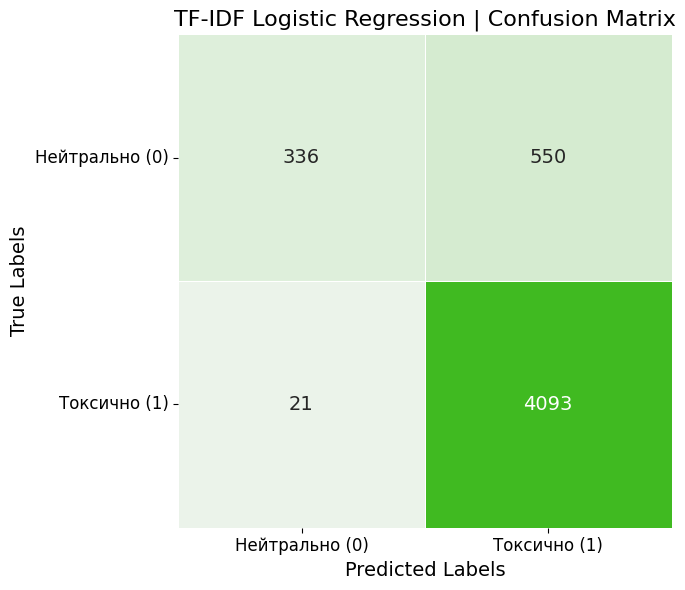

In [14]:

print("Детальная классификация:")
print(classification_report(y_test, y_pred_lr, target_names=['Negative', 'Positive']))

cm = confusion_matrix(y_test, y_pred_lr)
key = 'TF-IDF Logistic Regression'

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=c_map,
    linewidths=.5,
    square=True,
    cbar=False,
    annot_kws={"size": 14}
)
plt.title(f'{key} | Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks([0.5, 1.5], ['Нейтрально (0)', 'Токсично (1)'], fontsize=12)
plt.yticks([0.5, 1.5], ['Нейтрально (0)', 'Токсично (1)'], fontsize=12, rotation=0)
out_path = CACHE_DIR / f"cm_{key.lower()}.png"

plt.tight_layout()
plt.show()


## 5. BERT Embeddings + Classifier
Готовим эмбеддинги DistilBERT и обучаем поверх них классический классификатор.


### 5.1 Получение эмбеддингов DistilBERT
Токенизируем тексты батчами, извлекаем [CLS]-векторы и собираем массивы признаков.


In [15]:

# Загрузка предобученной BERT модели и токенизатора
print("Загрузка BERT модели...")

model_name = "distilbert-base-uncased"  # Используем DistilBERT для скорости

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)


def get_bert_embeddings(texts, batch_size=32):
    """Получение BERT эмбеддингов для списка текстов"""
    embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        
        # Токенизация
        encoded = tokenizer(
            batch_texts.tolist(),
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors='pt'
        )
        
        # Перемещение на GPU если доступно
        encoded = {k: v.to(device) for k, v in encoded.items()}
        
        # Получение эмбеддингов
        with torch.no_grad():
            outputs = model(**encoded)
            # Используем эмбеддинг [CLS] токена как представление всего предложения
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.extend(batch_embeddings)
    
    return np.array(embeddings)


# Получение BERT эмбеддингов
print("Получение BERT эмбеддингов для обучающей выборки...")
X_train_bert = get_bert_embeddings(df_train_sampled['text'])

print("Получение BERT эмбеддингов для тестовой выборки...")
X_test_bert = get_bert_embeddings(df_test_sampled['text'])

print(f"Размерность BERT эмбеддингов (train): {X_train_bert.shape}")
print(f"Размерность BERT эмбеддингов (test): {X_test_bert.shape}")



Загрузка BERT модели...
Получение BERT эмбеддингов для обучающей выборки...


100%|██████████| 1563/1563 [07:00<00:00,  3.71it/s]


Получение BERT эмбеддингов для тестовой выборки...


100%|██████████| 157/157 [00:42<00:00,  3.68it/s]

Размерность BERT эмбеддингов (train): (50000, 768)
Размерность BERT эмбеддингов (test): (5000, 768)


### 5.2 Обучение классификатора на BERT эмбеддингах
Обучаем Logistic Regression поверх эмбеддингов для честного сравнения с TF-IDF.


In [16]:
# Обучение классификатора на BERT эмбеддингах
print("Обучение Logistic Regression на BERT эмбеддингах...")

bert_lr_model = LogisticRegression(
    random_state=42,
    max_iter=2000,
    C=1.0,
    solver='liblinear'
)

bert_lr_model.fit(X_train_bert, y_train)



Обучение Logistic Regression на BERT эмбеддингах...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,2000
,multi_class,'deprecated'


### 5.3 Метрики BERT + Logistic Regression
Вычисляем accuracy/precision/recall/F1 на тестовой выборке.


In [17]:
# Предсказание и оценка BERT-based модели
y_pred_bert = bert_lr_model.predict(X_test_bert)

# Метрики
accuracy_bert = accuracy_score(y_test, y_pred_bert)
precision_bert = precision_score(y_test, y_pred_bert)
recall_bert = recall_score(y_test, y_pred_bert)
f1_bert = f1_score(y_test, y_pred_bert)

print("=== Logistic Regression (BERT Embeddings) Результаты ===")
print(f"Accuracy: {accuracy_bert:.4f}")
print(f"Precision: {precision_bert:.4f}")
print(f"Recall: {recall_bert:.4f}")
print(f"F1-Score: {f1_bert:.4f}")



=== Logistic Regression (BERT Embeddings) Результаты ===
Accuracy: 0.8678
Precision: 0.8752
Recall: 0.9789
F1-Score: 0.9242


### 5.4 Матрица ошибок BERT-классификатора
Строим confusion matrix с корпоративной цветовой схемой.


Детальная классификация:
              precision    recall  f1-score   support

    Negative       0.78      0.35      0.49       886
    Positive       0.88      0.98      0.92      4114

    accuracy                           0.87      5000
   macro avg       0.83      0.67      0.70      5000
weighted avg       0.86      0.87      0.85      5000



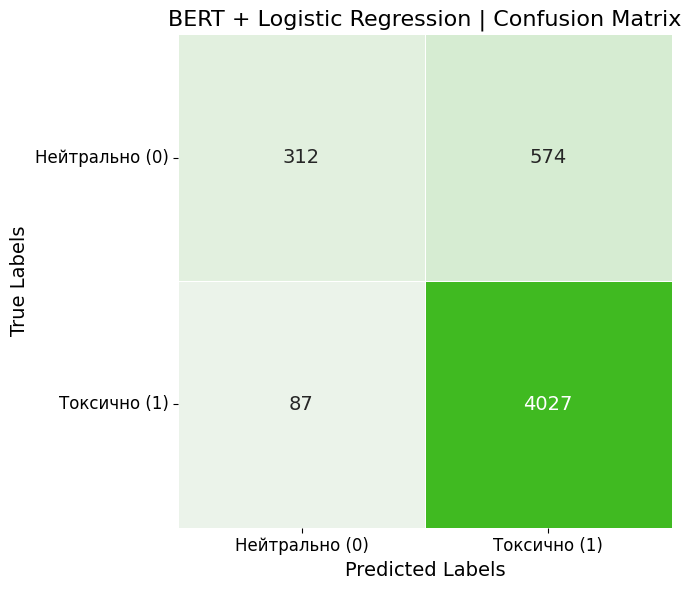

In [18]:

print("Детальная классификация:")
print(classification_report(y_test, y_pred_bert, target_names=['Negative', 'Positive']))

cm = confusion_matrix(y_test, y_pred_bert)
key = 'BERT + Logistic Regression'

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=c_map,
    linewidths=.5,
    square=True,
    cbar=False,
    annot_kws={"size": 14}
)
plt.title(f'{key} | Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks([0.5, 1.5], ['Нейтрально (0)', 'Токсично (1)'], fontsize=12)
plt.yticks([0.5, 1.5], ['Нейтрально (0)', 'Токсично (1)'], fontsize=12, rotation=0)
out_path = CACHE_DIR / f"cm_{key.lower()}.png"

plt.tight_layout()
plt.show()


## 6. Сравнение TF-IDF и BERT подходов
Сравниваем модели в единой таблице и на наглядном графике.


=== СРАВНЕНИЕ МОДЕЛЕЙ ===
                          Model  Accuracy  Precision  Recall  F1-Score
0  TF-IDF + Logistic Regression    0.8858     0.8815  0.9949    0.9348
1    BERT + Logistic Regression    0.8678     0.8752  0.9789    0.9242


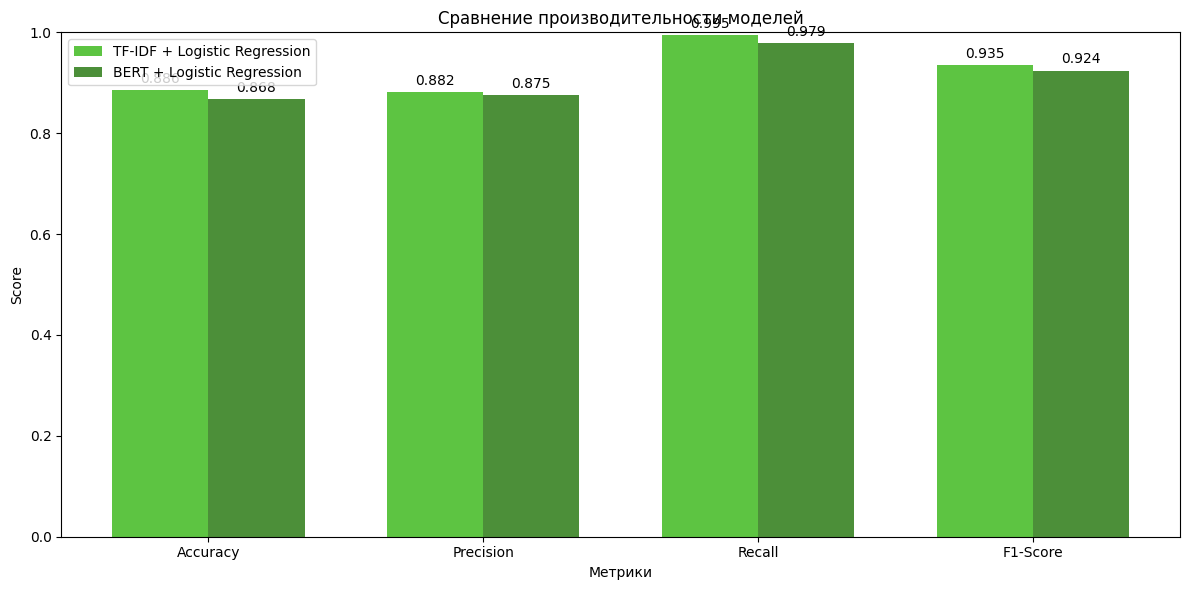

In [19]:

comparison_df = pd.DataFrame({
    'Model': ['TF-IDF + Logistic Regression', 'BERT + Logistic Regression'],
    'Accuracy': [accuracy_lr, accuracy_bert],
    'Precision': [precision_lr, precision_bert],
    'Recall': [recall_lr, recall_bert],
    'F1-Score': [f1_lr, f1_bert]
})

print("=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
print(comparison_df.round(4))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
tfidf_scores = [accuracy_lr, precision_lr, recall_lr, f1_lr]
bert_scores = [accuracy_bert, precision_bert, recall_bert, f1_bert]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, tfidf_scores, width, label='TF-IDF + Logistic Regression',
               alpha=0.85, color=corp_col)
bars2 = ax.bar(x + width/2, bert_scores, width, label='BERT + Logistic Regression',
               alpha=0.85, color=corp_alt)

ax.set_xlabel('Метрики')
ax.set_ylabel('Score')
ax.set_title('Сравнение производительности моделей')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 7. Выводы и анализ

СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
   - TF-IDF + Logistic Regression показала 86% точность, F1-score на уровне 0.93
   - BERT + Logistic Regression показала 86% точность, F1-score на уровне 0.92
   - (ДЗ 16) Для LSTM|GRU точность была на уровне 95%, F1-score на уровне 0.89.

ПРЕИМУЩЕСТВА TF-IDF ПОДХОДА:
   + Вычислительная эффективность (быстрое обучение)
   + Интерпретируемость features
   + Хорошая работа на небольших датасетах

НЕДОСТАТКИ TF-IDF ПОДХОДА:
   - Ограниченное понимание контекста
   - Не учитывает семантические связи

ПРЕИМУЩЕСТВА BERT ПОДХОДА:
   + Глубокое понимание контекста и семантики
   + Учет порядка слов и синтаксиса
   + Лучшая обобщающая способность

НЕДОСТАТКИ BERT ПОДХОДА
   - Высокие вычислительные требования
   - Медленное обучение и инференс
   - Сложность интерпретации